<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Fit_TMS_fMRI_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Fit_TMS_fMRI_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# --- Setup cell ---

# 1️⃣ Mount Google Drive (for data)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2️⃣ Clone GitHub repository (for code)
import os, sys, subprocess

repo_dir = "/content/BrainStim_ANN_fMRI_HCP"
if not os.path.exists(repo_dir):
    !git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git
else:
    print("Repo already exists ✅")

# 3️⃣ Define paths (TMS-fMRI)
data_dir = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects_tms_fmri")

# Where to save training outputs (kept separate from HCP)
weights_dir = os.path.join(preproc_dir, "trained_models_MLP_tms_fmri")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP_tms_fmri")  # keep naming consistent with your convention
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(ects_dir, exist_ok=True)

# 4️⃣ Add repo to import path + imports
sys.path.append(repo_dir)

import numpy as np
import matplotlib.pyplot as plt
import torch
from src import NPI
from src.preprocessing_tms_fmri import split_last_fraction, make_inputs_targets

import gc

# 5️⃣ Check device
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Running on:", torch.cuda.get_device_name(0))
else:
    print("⚠️  GPU not detected — training will run on CPU.")

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 586, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 586 (delta 28), reused 14 (delta 14), pack-reused 538 (from 1)
Receiving objects: 100% (586/586), 82.23 MiB | 18.87 MiB/s, done.
Resolving deltas: 100% (205/205), done.
PyTorch version: 2.9.0+cu126
CUDA available: True
Running on: Tesla T4


In [64]:
# --- Training parameters ---

#First training
# Training configuration:
#   Dataset: TMS-fMRI (task-rest only), population model
#   Method: MLP
#   Regions: 450
#   Steps: 3
#   Test fraction (per-subject): 0.1
#   Epochs: 50
#   Batch size: 64
#   learning_rate = 5e-4
#   l2_reg = 5e-5

# Choose ANN architecture: 'MLP', 'CNN', 'RNN', or 'VAR'
method = "MLP"

# Data / model hyperparameters
ROI_num = 450         # Tian 50 + Schaefer 400
using_steps = 3       # S: number of past steps used to predict next step

# Training hyperparameters
batch_size = 50
num_epochs = 150
learning_rate = 2.5e-4
l2_reg = 5e-5

# Population split rule (fixed): last 10% within each participant is test
test_fraction = 0.3

print(f"Training configuration:")
print(f"  Dataset: TMS-fMRI (task-rest only), population model")
print(f"  Method: {method}")
print(f"  Regions: {ROI_num}")
print(f"  Steps: {using_steps}")
print(f"  Test fraction (per-subject): {test_fraction}")
print(f"  Epochs: {num_epochs}")
print(f"  Batch size: {batch_size}")


Training configuration:
  Dataset: TMS-fMRI (task-rest only), population model
  Method: MLP
  Regions: 450
  Steps: 3
  Test fraction (per-subject): 0.3
  Epochs: 150
  Batch size: 50



### Notes on the split (important)

We **do not** concatenate raw time series across participants.

Instead:
1. For each participant, we split the **filtered signals** into train/test by taking the **last 10%** as test.
2. We create **Inputs/Targets within each split**, so no sample ever crosses a subject boundary.
3. We then concatenate **samples** across participants to form population train and test sets.


In [65]:

# --- Build population train/test datasets from per-subject signals ---

import glob

signal_files = sorted(glob.glob(os.path.join(preproc_dir, "sub-*_signals.npy")))
if len(signal_files) == 0:
    raise FileNotFoundError(
        f"No *_signals.npy found in {preproc_dir}. "
        "Run Process_TMS_fMRI_data.ipynb first (task-rest)."
    )

subject_ids = [os.path.basename(f).replace("_signals.npy", "") for f in signal_files]
print(f"Found {len(subject_ids)} subjects with signals.")

X_train_list, Y_train_list = [], []
X_test_list,  Y_test_list  = [], []

for sid in subject_ids:
    signals = np.load(os.path.join(preproc_dir, f"{sid}_signals.npy"))  # (T, 450)

    # Split last 10% test within subject
    sig_train, sig_test = split_last_fraction(signals, test_fraction=test_fraction)

    # Build Inputs/Targets within each split
    Xtr, Ytr = make_inputs_targets(sig_train, steps=using_steps)
    Xte, Yte = make_inputs_targets(sig_test,  steps=using_steps)

    # Some subjects may have too-short test splits; skip empty ones safely
    if Xtr.shape[0] > 0:
        X_train_list.append(Xtr); Y_train_list.append(Ytr)
    if Xte.shape[0] > 0:
        X_test_list.append(Xte);  Y_test_list.append(Yte)

    print(sid, "| signals:", signals.shape, "| train samples:", Xtr.shape[0], "| test samples:", Xte.shape[0])

# Concatenate samples across subjects
X_train = np.concatenate(X_train_list, axis=0)
Y_train = np.concatenate(Y_train_list, axis=0)
X_test  = np.concatenate(X_test_list, axis=0) if len(X_test_list) else np.zeros((0, using_steps * ROI_num), dtype=np.float32)
Y_test  = np.concatenate(Y_test_list, axis=0) if len(Y_test_list) else np.zeros((0, ROI_num), dtype=np.float32)

print("\nPopulation dataset shapes:")
print("  X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("  X_test: ", X_test.shape,  "Y_test: ", Y_test.shape)


Found 46 subjects with signals.
sub-NTHC1001 | signals: (210, 450) | train samples: 144 | test samples: 60
sub-NTHC1003 | signals: (210, 450) | train samples: 144 | test samples: 60
sub-NTHC1009 | signals: (210, 450) | train samples: 144 | test samples: 60
sub-NTHC1015 | signals: (420, 450) | train samples: 291 | test samples: 123
sub-NTHC1016 | signals: (210, 450) | train samples: 144 | test samples: 60
sub-NTHC1019 | signals: (420, 450) | train samples: 291 | test samples: 123
sub-NTHC1021 | signals: (210, 450) | train samples: 144 | test samples: 60
sub-NTHC1022 | signals: (210, 450) | train samples: 144 | test samples: 60
sub-NTHC1023 | signals: (210, 450) | train samples: 144 | test samples: 60
sub-NTHC1024 | signals: (210, 450) | train samples: 144 | test samples: 60
sub-NTHC1026 | signals: (210, 450) | train samples: 144 | test samples: 60
sub-NTHC1027 | signals: (210, 450) | train samples: 144 | test samples: 60
sub-NTHC1028 | signals: (210, 450) | train samples: 144 | test sam

In [66]:

# --- Train population model with a fixed (external) test set ---

import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_NN_fixed_test(
    model: nn.Module,
    X_train: np.ndarray,
    Y_train: np.ndarray,
    X_test: np.ndarray,
    Y_test: np.ndarray,
    batch_size: int = 64,
    num_epochs: int = 50,
    lr: float = 5e-4,
    l2: float = 0.0,
):
    """
    Train a model on (X_train,Y_train) and evaluate on (X_test,Y_test) each epoch.
    Mirrors NPI.train_NN style but avoids re-splitting internally.
    """
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    loss_fn = nn.MSELoss()

    train_inputs  = torch.tensor(X_train, dtype=torch.float32, device=device)
    train_targets = torch.tensor(Y_train, dtype=torch.float32, device=device)

    test_inputs  = torch.tensor(X_test, dtype=torch.float32, device=device) if X_test.size else None
    test_targets = torch.tensor(Y_test, dtype=torch.float32, device=device) if Y_test.size else None

    n_train = train_inputs.shape[0]
    train_epoch_loss, test_epoch_loss = [], []

    for ep in range(num_epochs):
        model.train()
        perm = torch.randperm(n_train, device=device)
        ep_loss = 0.0
        n_batches = 0

        for i in range(0, n_train, batch_size):
            idx = perm[i:i+batch_size]
            xb = train_inputs[idx]
            yb = train_targets[idx]

            pred = model(xb)
            loss = loss_fn(pred, yb)

            optim.zero_grad()
            loss.backward()
            optim.step()

            ep_loss += loss.item()
            n_batches += 1

        train_epoch_loss.append(ep_loss / max(1, n_batches))

        # test
        if test_inputs is not None and test_inputs.shape[0] > 0:
            model.eval()
            with torch.no_grad():
                pred = model(test_inputs)
                tloss = loss_fn(pred, test_targets).item()
            test_epoch_loss.append(tloss)
        else:
            test_epoch_loss.append(float("nan"))

        if (ep + 1) % 5 == 0 or ep == 0:
            print(f"Epoch {ep+1:3d}/{num_epochs} | train={train_epoch_loss[-1]:.6f} | test={test_epoch_loss[-1]:.6f}")

    return model, train_epoch_loss, test_epoch_loss

# Build model using existing NPI helper
model = NPI.build_model(method, ROI_num, using_steps)

model, train_loss, test_loss = train_NN_fixed_test(
    model,
    X_train, Y_train,
    X_test, Y_test,
    batch_size=batch_size,
    num_epochs=num_epochs,
    lr=learning_rate,
    l2=l2_reg,
)

print("✅ Training complete | Final test loss:", test_loss[-1])


Epoch   1/150 | train=0.541507 | test=0.508502
Epoch   5/150 | train=0.224194 | test=0.354030
Epoch  10/150 | train=0.152225 | test=0.301621
Epoch  15/150 | train=0.119485 | test=0.277446
Epoch  20/150 | train=0.097853 | test=0.263122
Epoch  25/150 | train=0.083683 | test=0.253073
Epoch  30/150 | train=0.074295 | test=0.255097
Epoch  35/150 | train=0.068783 | test=0.237638
Epoch  40/150 | train=0.060818 | test=0.233271
Epoch  45/150 | train=0.058753 | test=0.230052
Epoch  50/150 | train=0.053210 | test=0.224646
Epoch  55/150 | train=0.051833 | test=0.221737
Epoch  60/150 | train=0.046960 | test=0.220341
Epoch  65/150 | train=0.044513 | test=0.213688
Epoch  70/150 | train=0.043665 | test=0.213297
Epoch  75/150 | train=0.041481 | test=0.214534
Epoch  80/150 | train=0.040426 | test=0.209515
Epoch  85/150 | train=0.039917 | test=0.207557
Epoch  90/150 | train=0.037272 | test=0.208180
Epoch  95/150 | train=0.036415 | test=0.204323
Epoch 100/150 | train=0.036834 | test=0.205929
Epoch 105/150

In [67]:

# --- Save model + results (TMS-fMRI population) ---

import os, json

model_path = os.path.join(weights_dir, f"population_{method}_tms_fmri.pt")
torch.save(model, model_path)

results = {
    "dataset": "TMS-fMRI task-rest (population)",
    "method": method,
    "ROI_num": ROI_num,
    "using_steps": using_steps,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "l2_reg": l2_reg,
    "test_fraction_per_subject": test_fraction,
    "n_subjects": len(subject_ids),
    "n_train_samples": int(X_train.shape[0]),
    "n_test_samples": int(X_test.shape[0]),
    "model_path": model_path,
    "train_loss": train_loss,
    "test_loss": test_loss,
}

results_path = os.path.join(preproc_dir, f"ANN_results_{method}_tms_fmri_population.json")
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

print("💾 Saved model:", model_path)
print("💾 Saved results:", results_path)


💾 Saved model: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/trained_models_MLP_tms_fmri/population_MLP_tms_fmri.pt
💾 Saved results: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_results_MLP_tms_fmri_population.json


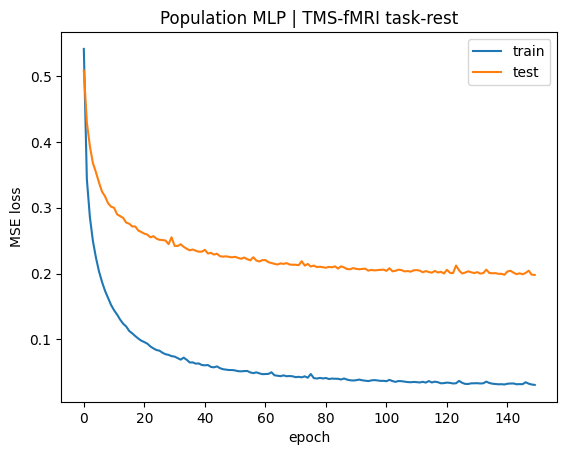

In [68]:

# --- Visualize learning curves ---

plt.figure()
plt.plot(train_loss, label="train")
plt.plot(test_loss, label="test")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title(f"Population {method} | TMS-fMRI task-rest")
plt.show()


# Example simulate single subject time series

In [69]:
# --- Define helper to load model (full model or checkpoint) ---
def load_model(model_path, inputs, targets):
    ckpt = torch.load(model_path, map_location=device, weights_only=False)
    if hasattr(ckpt, "eval"):  # full model saved with torch.save(model)
        model = ckpt.to(device)
        model.eval()
        return model
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        method = ckpt.get("method", "MLP")
        ROI_num = ckpt.get("ROI_num", targets.shape[-1])
        using_steps = ckpt.get("using_steps", inputs.shape[-2] if inputs.ndim > 1 else 1)
        model = NPI.build_model(method, ROI_num, using_steps).to(device)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        return model
    raise ValueError("Unrecognized model file format")

In [133]:
# Single subject plots
idd=6
sig_path = os.path.join(preproc_dir, f"{subject_ids[idd]}_signals.npy")
inp_path = os.path.join(preproc_dir, f"{subject_ids[idd]}_inputs.npy")
tgt_path = os.path.join(preproc_dir, f"{subject_ids[idd]}_targets.npy")
mdl_path = os.path.join(weights_dir,  f"population_MLP_tms_fmri.pt")

Z = np.load(sig_path)
X = np.load(inp_path)             # (M, S*N)
Y = np.load(tgt_path)             # (M, N)

# Load model
model = load_model(mdl_path, X, Y)

In [134]:
Z.shape[0]+30

240

In [167]:
S=3 #number of steps
N=Z.shape[1] #number of regions
Zsim = NPI.model_time_series(model, np.zeros((S,N)), tlen=Z.shape[0]+30, noise_strength=0.3)
Zsim.shape

(243, 450)

In [168]:
# Empirical vs simulated time series, FC, and dFC
from scipy import stats

def go_edge(tseries):
    nregions=tseries.shape[1]
    Blen=tseries.shape[0]
    nedges=int(nregions**2/2-nregions/2)
    iTriup= np.triu_indices(nregions,k=1)
    gz=stats.zscore(tseries)
    Eseries = gz[:,iTriup[0]]*gz[:,iTriup[1]]
    return Eseries

def dFC(tseries):
    return np.corrcoef(go_edge(tseries))

test_dur=Z.shape[0] #int(len(Z)-len(Z)/100*80) #3000

emp=Z[-test_dur:,:]
sim=Zsim[-test_dur:,:]

FC_emp=np.corrcoef(emp.T)
FC_sim=np.corrcoef(sim.T)

dFC_emp=dFC(emp)
dFC_sim=dFC(sim)

In [169]:
FC_emp.shape

(450, 450)

In [170]:
dFC_emp.shape

(210, 210)

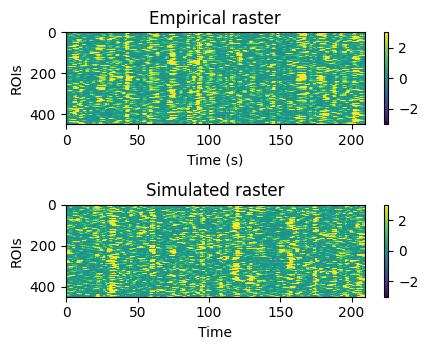

In [171]:
plt.figure(figsize=(4.6,3.6))
plt.subplot(2,1,1)
plt.title('Empirical raster')
plt.imshow((stats.zscore(emp,axis=0)**2).T,aspect='auto',vmin=-3,vmax=3,cmap='viridis',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('ROIs')
plt.subplot(2,1,2)
plt.title('Simulated raster')
plt.imshow((stats.zscore(sim,axis=0)**2).T,aspect='auto',vmin=-3,vmax=3,cmap='viridis',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('ROIs')
#plt.axis('off')
plt.tight_layout()
plt.show()

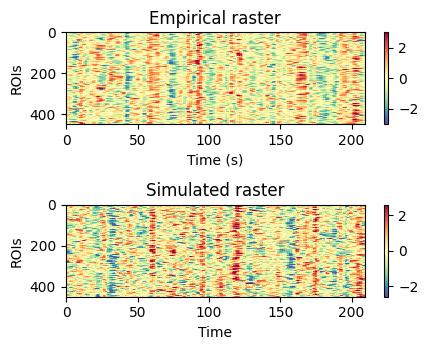

In [172]:
plt.figure(figsize=(4.6,3.6))
plt.subplot(2,1,1)
plt.title('Empirical raster')
plt.imshow(stats.zscore(emp,axis=0)[:,:].T,aspect='auto',vmin=-3.,vmax=3.,cmap='Spectral_r',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time (s)')
plt.ylabel('ROIs')
plt.subplot(2,1,2)
plt.title('Simulated raster')
plt.imshow(stats.zscore(sim,axis=0)[:,:].T,aspect='auto',vmin=-2.6,vmax=2.6,cmap='Spectral_r',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('ROIs')
#plt.axis('off')
plt.tight_layout()
plt.show()

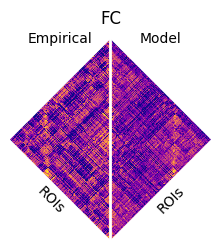

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon

# FC_emp and FC_sim are square (n x n) numpy arrays
# Example color limits (change if you like)
vmin, vmax = 0, 1

# We'll place the (0..1, 0..1) image into a square [-1,1]x[-1,1] then rotate 45°
extent = (-1, 1, -1, 1)

fig, ax = plt.subplots(figsize=(2.6,2.6))
ax.set_aspect('equal')
ax.set_axis_off()

# 45° rotation for anything that should align with the matrix axes (images + grid)
rot = Affine2D().rotate_deg(45) + ax.transData

# --- draw left (Empirical) half ---
im_emp = ax.imshow(FC_emp, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='plasma', transform=rot,interpolation='nearest')
# clip to left triangle (x <= 0 in unrotated data coords)

# Y label (left, vertical)
clip_left = Polygon([(-1, 0), (0, 1), (0, -1)], closed=True,
                    facecolor='none', edgecolor='none', transform=ax.transData)
im_emp.set_clip_path(clip_left)

# --- draw right (Model) half ---
im_sim = ax.imshow(FC_sim, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='plasma', transform=rot,interpolation='nearest')

# Y label (left, vertical)
# clip to right triangle (x >= 0)
clip_right = Polygon([(0, -1), (0, 1), (1, 0)], closed=True,
                     facecolor='none', edgecolor='none', transform=ax.transData)
im_sim.set_clip_path(clip_right)

# central separator
ax.plot([0, 0], [-1, 1], color='w', lw=2)

# labels
ax.text(0., 1.2, 'FC', color='k', ha='center', va='center',
        fontsize=12)

ax.text(-0.5, 1.0, 'Empirical', color='k', ha='center', va='center',
        fontsize=10)
ax.text(0.5, 1.0, 'Model', color='k', ha='center', va='center',
        fontsize=10)

# Y-axis label (left center, rotated)
ax.text(-.6, -0.6, 'ROIs', ha='center', va='center',
        fontsize=10, rotation=-45)

# Y-axis label (left center, rotated)
ax.text(0.6, -0.6, 'ROIs', ha='center', va='center',
        fontsize=10, rotation=45)

plt.tight_layout()
#plt.savefig('FC_emp_vs_sim.png',dpi=300, transparent=True)
plt.show()

In [174]:
np.corrcoef(FC_emp[np.triu_indices(450,1)],FC_sim[np.triu_indices(450,1)])

array([[1.        , 0.41769968],
       [0.41769968, 1.        ]])

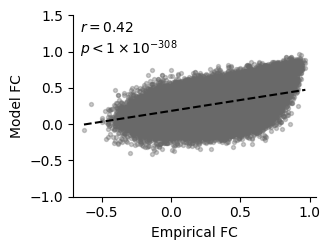

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# --- take upper triangle (excluding diagonal) ---
tri = np.triu_indices_from(FC_emp, k=1)
x = FC_emp[tri].astype(float).ravel()
y = FC_sim[tri].astype(float).ravel()

# remove NaNs / infs if any
m = np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# stats
r, p = pearsonr(x, y)
lr = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr, intercept_stderr

# --- plot ---
fig, ax = plt.subplots(figsize=(3.4, 2.6))
ax.scatter(x, y, s=8, alpha=0.35,c='dimgray')

# regression line
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, lr.slope * xx + lr.intercept, linewidth=1.5,c='k',linestyle='--')

# identity line for reference
#lo, hi = min(x.min(), y.min()), max(x.max(), y.max())
#ax.plot([lo, hi], [lo, hi], linestyle='--', linewidth=1)

ax.set_xlabel('Empirical FC')
ax.set_ylabel('Model FC')
#ax.set_title('Empirical vs. Model FC')

# format p-value as mantissa × 10^{exponent}
if p == 0:
    p_str = r"$p < 1\times 10^{-308}$"   # avoids log10(0)
else:
    exponent = int(np.floor(np.log10(p)))
    mantissa = p / 10**exponent
    p_str = rf"$p = {mantissa:.2f}\times 10^{{{exponent}}}$"

# annotate correlation + p-value
ax.text(0.03, 0.97, rf"$r = {r:.2f}$" + "\n" + p_str,
        transform=ax.transAxes, ha="left", va="top")

# turn off top and right axes spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ticks = ax.get_xticks()
ax.set_yticks(ticks)

plt.tight_layout()
#plt.savefig('FC_emp_vs_sim_scatter.png',dpi=300, transparent=True)
plt.show()

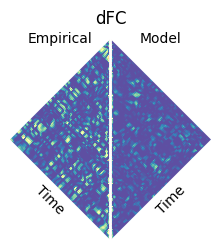

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon

# dFC_emp and dFC_sim are square (n x n) numpy arrays
# Example color limits (change if you like)
vmin, vmax = -0, 1.

# We'll place the (0..1, 0..1) image into a square [-1,1]x[-1,1] then rotate 45°
extent = (-1, 1, -1, 1)

fig, ax = plt.subplots(figsize=(2.6,2.6))
ax.set_aspect('equal')
ax.set_axis_off()

# 45° rotation for anything that should align with the matrix axes (images + grid)
rot = Affine2D().rotate_deg(45) + ax.transData

# --- draw left (Empirical) half ---
im_emp = ax.imshow(dFC_emp, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r', transform=rot,interpolation='nearest')
# clip to left triangle (x <= 0 in unrotated data coords)

# Y label (left, vertical)
clip_left = Polygon([(-1, 0), (0, 1), (0, -1)], closed=True,
                    facecolor='none', edgecolor='none', transform=ax.transData)
im_emp.set_clip_path(clip_left)

# --- draw right (Model) half ---
im_sim = ax.imshow(dFC_sim, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r', transform=rot,interpolation='nearest')

# Y label (left, vertical)
# clip to right triangle (x >= 0)
clip_right = Polygon([(0, -1), (0, 1), (1, 0)], closed=True,
                     facecolor='none', edgecolor='none', transform=ax.transData)
im_sim.set_clip_path(clip_right)

# central separator
ax.plot([0, 0], [-1, 1], color='w', lw=2)

# labels
ax.text(0., 1.2, 'dFC', color='k', ha='center', va='center',
        fontsize=12)

ax.text(-0.5, 1.0, 'Empirical', color='k', ha='center', va='center',
        fontsize=10)
ax.text(0.5, 1.0, 'Model', color='k', ha='center', va='center',
        fontsize=10)

# Y-axis label (left center, rotated)
ax.text(-.6, -0.6, 'Time', ha='center', va='center',
        fontsize=10, rotation=-45)

# Y-axis label (left center, rotated)
ax.text(0.6, -0.6, 'Time', ha='center', va='center',
        fontsize=10, rotation=45)

plt.tight_layout()
#plt.savefig('dFC_emp_vs_sim.png',dpi=300, transparent=True)
plt.show()

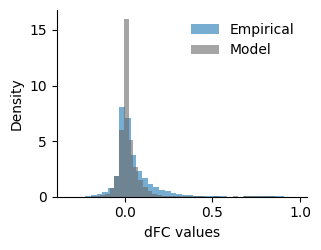

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# --- take upper triangle (excluding diagonal) ---
tri = np.triu_indices_from(dFC_emp, k=1)
x = dFC_emp[tri].astype(float).ravel()
y = dFC_sim[tri].astype(float).ravel()

# remove NaNs / infs if any
m = np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# --- KS test ---
D, p = ks_2samp(x, y)

# format p-value as mantissa × 10^{exponent}
if p == 0:
    p_str = r"$p < 1\times 10^{-308}$"
else:
    exponent = int(np.floor(np.log10(p)))
    mantissa = p / 10**exponent
    p_str = rf"$p = {mantissa:.2f}\times 10^{{{exponent}}}$"

# --- plot ---
fig, ax = plt.subplots(figsize=(3.4, 2.6))

# histograms
bins = 40
ax.hist(x, bins=bins, alpha=0.6, label="Empirical", density=True)
ax.hist(y, bins=bins, alpha=0.6, label="Model", density=True, color='dimgray')

ax.set_xlabel('dFC values')
ax.set_ylabel('Density')

# annotate KS test results
#ax.text(0.03, 0.97, rf"$D = {D:.2f}$" + "\n" + p_str,
#        transform=ax.transAxes, ha="left", va="top")

# tidy up axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend (move outside the plot to avoid overlap)
# Put legend at upper right, labels below the boxes
# shrink current axis by 20% (leave room on the right)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# now put legend to the right
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
#plt.savefig('dFC_emp_vs_sim_hist.png', dpi=300, transparent=True)
plt.show()

# All Subjects (I only removed subject 6 because it does not fit well!)

In [198]:
# Empirical static and dynamic FC for all subjects
FCs_emp={}
dFCs_emp={}
FCs_sim={}
dFCs_sim={}
for isu in range(len(subject_ids)):
  sig_path = os.path.join(preproc_dir, f"{subject_ids[isu]}_signals.npy")
  inp_path = os.path.join(preproc_dir, f"{subject_ids[isu]}_inputs.npy")
  tgt_path = os.path.join(preproc_dir, f"{subject_ids[isu]}_targets.npy")
  mdl_path = os.path.join(weights_dir,  f"population_MLP_tms_fmri.pt")

  Z = np.load(sig_path)
  X = np.load(inp_path)             # (M, S*N)
  Y = np.load(tgt_path)             # (M, N)

  # Load model
  model = load_model(mdl_path, X, Y)

  S=3 #number of steps
  N=Z.shape[1] #number of regions
  Zsim = NPI.model_time_series(model, np.zeros((S,N)), tlen=240, noise_strength=.28)

  test_dur=180 #int(len(Z)-len(Z)/100*80)

  emp=Z[-test_dur:,:]
  sim=Zsim[-test_dur:,:]

  FCs_emp[isu]=np.corrcoef(emp.T)
  FCs_sim[isu]=np.corrcoef(sim.T)

  dFCs_emp[isu]=dFC(emp)
  dFCs_sim[isu]=dFC(sim)

In [199]:
T=emp.shape[0]   # time points
N=emp.shape[1]   # number of regions
tri_N=np.triu_indices(N,1)
tri_T=np.triu_indices(T,1)

In [200]:
Corr_FC_emp_VS_sim={}
Fluidity_emp={}
Fluidity_sim={}
for isu in range(len(subject_ids)):
  Corr_FC_emp_VS_sim[isu]=stats.pearsonr(FCs_emp[isu][tri_N],FCs_sim[isu][tri_N])[0]
  Fluidity_emp[isu]=np.var(dFCs_emp[isu][tri_T])
  Fluidity_sim[isu]=np.var(dFCs_sim[isu][tri_T])

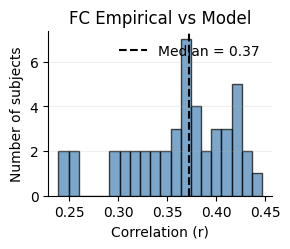

In [201]:
data = np.asarray(list(Corr_FC_emp_VS_sim.values()))

# --- Plot histogram ---
fig, ax = plt.subplots(figsize=(3, 2.6))

ax.hist(data, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.median(data), color='k', linestyle='--', lw=1.5, label=f"Median = {np.median(data):.2f}")

# Cosmetic tweaks
ax.set_title('FC Empirical vs Model')
ax.set_xlabel("Correlation (r)")
ax.set_ylabel("Number of subjects")
#ax.set_xlim(0.7, 1.0)
ax.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

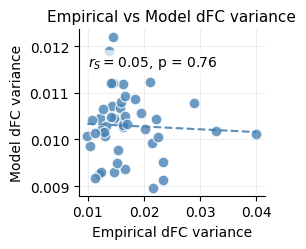

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr

# --- align subjects present in both ---
idx = sorted(set(Fluidity_emp.keys()) & set(Fluidity_sim.keys()))
x = np.array([Fluidity_emp[i] for i in idx], float)  # empirical
y = np.array([Fluidity_sim[i] for i in idx], float)  # model

# --- Scatter plot ---
fig, ax = plt.subplots(figsize=(2.9, 2.6))

sc = ax.scatter(x, y, s=60, color='steelblue',
                edgecolor='white', linewidth=0.9, alpha=0.8)

# --- Regression line ---
lr = linregress(x, y)
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, lr.slope*xx + lr.intercept, color='steelblue',
        linewidth=1.5, linestyle="--", alpha=0.9)

# --- Identity line (y=x) ---
#lo, hi = min(x.min(), y.min()), max(x.max(), y.max())
#ax.plot([lo, hi], [lo, hi], ls="--", lw=1, color="k", alpha=0.4)
#ax.set_xlim(lo, hi)
#ax.set_ylim(lo, hi)

# --- Correlation ---
r, p = stats.spearmanr(x, y)
ax.text(0.05, 0.85, f"$r_S = {r:.2f}$, p = {p:.2g}",
        transform=ax.transAxes, va='top', ha='left', fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))

# --- Labels & style ---
ax.set_xlabel("Empirical dFC variance")
ax.set_ylabel("Model dFC variance")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.2)
ax.set_title("Empirical vs Model dFC variance", fontsize=11)

plt.tight_layout()
plt.show()


In [ ]:
#EC_t = NPI.model_ECt(model, input_X=X[:400,:], target_Y=Y[:400,:], pert_strength=0.1)

In [ ]:
#EC_t.shape

(400, 450, 450)